In [1]:
# !pip install pandas

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras import datasets

In [4]:
from tensorflow import keras

In [5]:
from keras.optimizers import adam_v2
from keras.utils.np_utils import to_categorical  

In [20]:
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [12]:
import time

In [13]:
from sklearn.utils import resample

In [14]:
import PIL
from PIL import Image

## Index

1. [Method 1 - Logistic Regression](#Method-1---Logistic-Regression)
2. [Method 2 - Support Vector Machines](#Method-2---Support-Vector-Machines)
    1. [Linear Kernel](#Linear-Kernel)
    2. [Polynomial Kernel](#Polynomial-Kernel)
    3. [RBF kernel](#RBF-kernel)
    4. [PCA](#PCA)
3. [Method 3 - Deep Neural Network without Convolution](#Method-3---Deep-Neural-Network-without-Convolution)
4. [Method 4 - Deep Neural Network with Convolution](#Method-4---Deep-Neural-Network-with-Convolution)


## Metrics


1. Accuracy
2. Confusion Matrix

Classification report

3. Precision (macro, micro, ave)
4. Recall (macro, micro, ave)
5. F1 (macro, micro, ave)
6. ROC Curves
6. Log time



[Classification Metrics](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd)

## Loading the Data

In [10]:
cifar10 = datasets.cifar10.load_data()

In [11]:
cifar10[1][0].shape

(10000, 32, 32, 3)

In [12]:
cifar10[0][1].shape

(50000, 1)

In [13]:
x_train,y_train, x_test , y_test = cifar10[0][0], cifar10[0][1], cifar10[1][0], cifar10[1][1]

In [14]:
print(f"X train: {x_train.shape}")
print(f"Y train: {y_train.shape}")
print(f"X test: {x_test.shape}")
print(f"Y test: {y_test.shape}")

X train: (50000, 32, 32, 3)
Y train: (50000, 1)
X test: (10000, 32, 32, 3)
Y test: (10000, 1)


In [15]:
classes = list(np.unique(y_train))

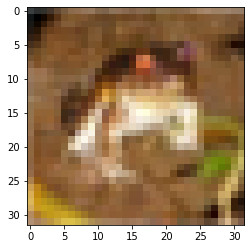

In [16]:
plt.imshow(x_train[0])

In [17]:
len(classes)

10

In [18]:

labels = ['airplane',
'automobile', 
'bird',
'cat',
'deer',
'dog',
'frog',
'horse', 
'ship', 
'truck']

label_dict = {idx: val for idx, val in enumerate(labels)}

In [19]:
label_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

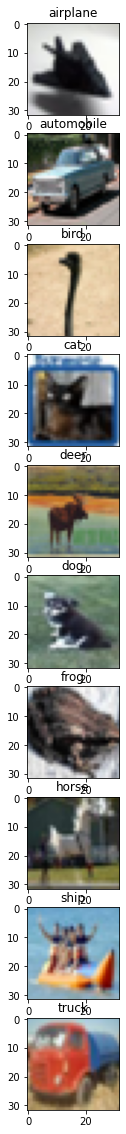

In [20]:
#exploring the data
c = 0
plt.figure(figsize=(100,20))
ax = [None for i in range(len(classes))]
for i in range(len(y_train)):
    if y_train[i] == c:
        ax[c] = plt.subplot(10, 1, c+1)
        ax[c].imshow(x_train[i])
        plt.title(label_dict[c])
        c += 1
    if c == len(classes):
        break

plt.show()

## Method 1 - Logistic Regression

Loading the dataset and building train and test sets

In [4]:
# dependencies
import numpy as np

#################### Your Code ####################
ROOT_PATH='/Users/smoothoperator/Documents/SML/Final Project/'  # Modify this line with the path to the folder where folder "cifar-10-batches-py" locate
###################################################

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
#Define batches
batch1 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_1")
batch2 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_2")
batch3 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_3")
batch4 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_4")
batch5 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_5")
test_batch = unpickle(ROOT_PATH+"cifar-10-batches-py/test_batch")

In [6]:
def load_data0(btch):
    labels = btch[b'labels']
    imgs = btch[b'data'].reshape((-1, 32, 32, 3))
    
    res = []
    for ii in range(imgs.shape[0]):
        img = imgs[ii].copy()
        img = np.fliplr(np.rot90(np.transpose(img.flatten().reshape(3,32,32)), k=-1))
        res.append(img)
    imgs = np.stack(res)
    return labels, imgs


def load_data():
    x_train_l = []
    y_train_l = []
    for ibatch in [batch1, batch2, batch3, batch4, batch5]:
        labels, imgs = load_data0(ibatch)
        x_train_l.append(imgs)
        y_train_l.extend(labels)
    x_train = np.vstack(x_train_l)
    y_train = np.vstack(y_train_l)
    
    x_test_l = []
    y_test_l = []
    labels, imgs = load_data0(test_batch)
    x_test_l.append(imgs)
    y_test_l.extend(labels)
    x_test = np.vstack(x_test_l)
    y_test = np.vstack(y_test_l)
    return (x_train, y_train), (x_test, y_test)


In [7]:
(x_train, y_train), (x_test, y_test) = load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
del batch1, batch2, batch3, batch4, batch5, test_batch

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### Logistic Regression Specific

In [8]:

### Preprocessing the data and visualising some samples
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def visualize_sample(X_train, y_train, classes, samples_per_class=5):

    num_classes = len(classes)
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y) # get all the indexes of cls
        idxs = np.random.choice(idxs, samples_per_class, replace=False) #randomly choose 5 of these indices
        for i, idx in enumerate(idxs): # plot the image one by one
            plt_idx = i * num_classes + y + 1 # i*num_classes and y+1 determine the row and column respectively
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
    
def preprocessing_CIFAR10_data(X_train, y_train, X_test, y_test):
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1)) # [50,000, 3072]
    
    X_test = np.reshape(X_test, (X_test.shape[0], -1)) # [10000, 3072]
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)

    X_train = X_train - mean_image
   
    X_test = X_test - mean_image
    
    
    # Add bias dimension and NOT transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
   
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    return X_train, y_train, X_test, y_test

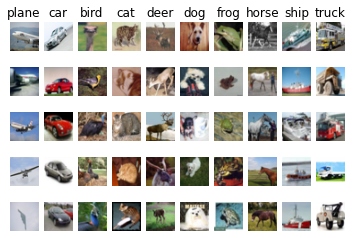

(50000, 3073)
(50000, 1)
<class 'numpy.ndarray'>
(10000, 3073)
(10000, 1)


In [15]:
#Visualise some samples before we preprocess it to feed to the model
visualize_sample(x_train, y_train, classes)
#Preprocessing the raw data
X_train, y_train, X_test, y_test = preprocessing_CIFAR10_data(x_train, y_train, x_test, y_test)
print(X_train.shape)
print(y_train.shape)
print(type(X_train))
print(X_test.shape)
print(y_test.shape)

### Importing and Training LR Model

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:

model_lr = LogisticRegression()
train_lr = model_lr.fit(X_train,y_train)
y_preds = model_lr.predict(X_test)

/Users/smoothoperator/opt/anaconda3/envs/smoothenv/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/smoothoperator/opt/anaconda3/envs/smoothenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
print("Classification Report: Logistic Regression \n")
print(classification_report(y_test, y_preds, target_names=classes))
print("Model Accuracy: {}%".format(metrics.accuracy_score(y_test,y_preds)*100))

Classification Report: Logistic Regression 

              precision    recall  f1-score   support

       plane       0.46      0.49      0.47      1000
         car       0.43      0.47      0.45      1000
        bird       0.33      0.27      0.30      1000
         cat       0.29      0.23      0.25      1000
        deer       0.36      0.28      0.31      1000
         dog       0.33      0.32      0.32      1000
        frog       0.39      0.48      0.43      1000
       horse       0.45      0.44      0.45      1000
        ship       0.47      0.57      0.52      1000
       truck       0.43      0.48      0.45      1000

    accuracy                           0.40     10000
   macro avg       0.40      0.40      0.40     10000
weighted avg       0.40      0.40      0.40     10000

Model Accuracy: 40.2%


## Method 2 - Support Vector Machines

In [41]:
from sklearn import svm

### Treat data

In [42]:
## Reshaping the data
x_train_svm = x_train.reshape(x_train.shape[0], -1)
x_test_svm = x_test.reshape(x_test.shape[0], -1)

In [43]:
## Normalizing the data
x_train_svm = x_train_svm / 255.0
x_test_svm = x_test_svm / 255.0

In [22]:
x_train_split = []
x_test_split = []
y_train_split = []
y_test_split = []

In [23]:
skf  = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(x_train_svm, y_train):
    x_train_split.append(x_train_svm[train_index])
    y_train_split.append(y_train[train_index])
    x_test_split.append(x_train_svm[test_index])
    y_test_split.append(y_train[test_index])
#     X_train_split, X_test_split = x_train_svm[train_index], x_train_svm[test_index]
#     y_train_split, y_test_split = y_train[train_index], y_train[test_index]

In [29]:
x_train_sample, y_train_sample = resample(x_train_svm, y_train, n_samples = 5000, stratify=y_train)

In [31]:
x_train_sample.shape

(5000, 3072)

In [32]:
y_train_sample.shape

(5000, 1)

### Linear Kernel


In [44]:
%time
clf = svm.SVC(probability = False, kernel = 'linear', verbose=True)



Wall time: 0 ns


In [45]:
%time
start = time.time()
clf.fit(x_train_svm, y_train)
print(time.time() - start)

Wall time: 0 ns


C:\Users\tanma\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LibSVM]8503.81238079071


In [46]:
y_train_pred = clf.predict(x_test_svm)
# y_test_pred = clf.predict(x_test_svm)

In [47]:
print(classification_report(y_test, y_train_pred, target_names=labels))

              precision    recall  f1-score   support

    airplane       0.39      0.48      0.43      1000
  automobile       0.41      0.43      0.42      1000
        bird       0.27      0.31      0.29      1000
         cat       0.25      0.26      0.26      1000
        deer       0.31      0.27      0.29      1000
         dog       0.30      0.29      0.29      1000
        frog       0.43      0.43      0.43      1000
       horse       0.45      0.37      0.41      1000
        ship       0.52      0.51      0.51      1000
       truck       0.44      0.40      0.42      1000

    accuracy                           0.38     10000
   macro avg       0.38      0.37      0.37     10000
weighted avg       0.38      0.38      0.37     10000



### Polynomial Kernel

In [48]:
%time
clf = svm.SVC(probability = False, kernel = 'poly', verbose=True)


Wall time: 0 ns


In [49]:
%time
start = time.time()
clf.fit(x_train_svm, y_train)
print(time.time() - start)

Wall time: 0 ns


C:\Users\tanma\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LibSVM]4046.01628780365


In [50]:
y_train_pred = clf.predict(x_test_svm)

In [51]:
print(classification_report(y_test, y_train_pred, target_names=labels))

              precision    recall  f1-score   support

    airplane       0.57      0.62      0.60      1000
  automobile       0.63      0.63      0.63      1000
        bird       0.39      0.43      0.41      1000
         cat       0.35      0.38      0.37      1000
        deer       0.45      0.50      0.47      1000
         dog       0.46      0.39      0.42      1000
        frog       0.53      0.59      0.56      1000
       horse       0.63      0.53      0.57      1000
        ship       0.67      0.65      0.66      1000
       truck       0.61      0.53      0.57      1000

    accuracy                           0.52     10000
   macro avg       0.53      0.52      0.53     10000
weighted avg       0.53      0.52      0.53     10000



### RBF kernel

In [52]:
%time
clf = svm.SVC(probability = False, verbose=True)


Wall time: 0 ns


In [53]:
%time
start = time.time()
clf.fit(x_train_svm, y_train)
print(time.time() - start)

Wall time: 0 ns


C:\Users\tanma\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LibSVM]3963.6770956516266


In [ ]:
y_train_pred = clf.predict(x_test_svm)

In [ ]:
print(classification_report(y_test, y_train_pred, target_names=labels))

## PCA

In [24]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA(n_components=300)

In [26]:
x_train_svm_pca = pca.fit_transform(x_train_svm)

In [27]:
cum_sum = []
s = 0
for i in pca.explained_variance_ratio_:
    s += i
    cum_sum.append(s)

In [28]:
cum_sum

[0.29076629890565087,
 0.40329773567599536,
 0.4702418753117771,
 0.5070064638887163,
 0.5430948931228546,
 0.5711871913961672,
 0.5983171118651189,
 0.6199887368278603,
 0.6406351508677385,
 0.6550151658126417,
 0.6681207933381981,
 0.6787805775902308,
 0.6892803899524201,
 0.6993230751357148,
 0.7085078977530169,
 0.7166818992532972,
 0.7240779782937709,
 0.7312392769569489,
 0.7381139930984548,
 0.7445464277918177,
 0.7504903913996879,
 0.7563639385394316,
 0.7613196128559221,
 0.7662275334469394,
 0.7710320538036006,
 0.7756908260331156,
 0.7802043060264592,
 0.7846408465749712,
 0.7886486548202708,
 0.7925873158876696,
 0.7962494908524731,
 0.7995808859926483,
 0.8028205378906518,
 0.8059229986236564,
 0.8089988675099632,
 0.8119113643342388,
 0.8145235539947782,
 0.8171161598221494,
 0.8196596126672557,
 0.8221433891232964,
 0.8245701007372489,
 0.8268632961179689,
 0.829145042908623,
 0.8313602223935977,
 0.8334628244720523,
 0.835530140188104,
 0.8374547122108164,
 0.8393585033

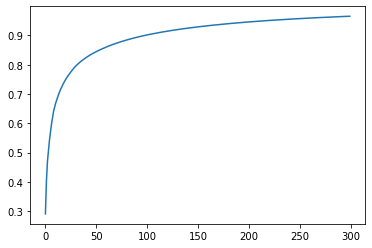

In [29]:
plt.plot(cum_sum)

In [30]:
x_train_svm_pca = pca.transform(x_train_svm)
x_test_svm_pca = pca.transform(x_test_svm)

### Linear Kernel


In [31]:
%time
clf = svm.SVC(probability = False, kernel = 'linear', verbose=True)



Wall time: 0 ns


In [32]:
%time
start = time.time()
clf.fit(x_train_svm_pca, y_train)
print(time.time() - start)

Wall time: 0 ns
[LibSVM]

C:\Users\tanma\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


3945.4434502124786


In [95]:
y_train_pred = clf.predict(x_test_svm_pca)
# y_test_pred = clf.predict(x_test_svm)

In [97]:
print(classification_report(y_test, y_train_pred, target_names=labels))

              precision    recall  f1-score   support

    airplane       0.46      0.52      0.48      1000
  automobile       0.47      0.50      0.49      1000
        bird       0.30      0.30      0.30      1000
         cat       0.29      0.30      0.30      1000
        deer       0.37      0.31      0.34      1000
         dog       0.35      0.33      0.34      1000
        frog       0.44      0.49      0.47      1000
       horse       0.49      0.43      0.46      1000
        ship       0.53      0.53      0.53      1000
       truck       0.47      0.47      0.47      1000

    accuracy                           0.42     10000
   macro avg       0.42      0.42      0.42     10000
weighted avg       0.42      0.42      0.42     10000



### Polynomial Kernel

In [33]:
%time
clf = svm.SVC(probability = False, kernel = 'poly', verbose=True)


Wall time: 0 ns


In [34]:
%time

start = time.time()
clf.fit(x_train_svm_pca, y_train)
print(time.time() - start)

Wall time: 0 ns
[LibSVM]

C:\Users\tanma\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


1162.2159740924835


In [35]:
y_train_pred = clf.predict(x_test_svm_pca)

In [36]:
print(classification_report(y_test, y_train_pred, target_names=labels))

              precision    recall  f1-score   support

    airplane       0.60      0.51      0.55      1000
  automobile       0.64      0.55      0.59      1000
        bird       0.27      0.45      0.34      1000
         cat       0.37      0.28      0.32      1000
        deer       0.29      0.54      0.38      1000
         dog       0.46      0.32      0.38      1000
        frog       0.50      0.45      0.47      1000
       horse       0.63      0.43      0.51      1000
        ship       0.65      0.61      0.63      1000
       truck       0.64      0.53      0.58      1000

    accuracy                           0.47     10000
   macro avg       0.51      0.47      0.48     10000
weighted avg       0.51      0.47      0.48     10000



### RBF kernel

In [37]:
%time
clf = svm.SVC(probability = False, verbose=True)


Wall time: 0 ns


In [38]:
%time
start = time.time()
clf.fit(x_train_svm_pca, y_train)
print(time.time() - start)

Wall time: 0 ns
[LibSVM]

C:\Users\tanma\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


823.496440410614


In [39]:
y_train_pred = clf.predict(x_test_svm_pca)

In [40]:
print(classification_report(y_test, y_train_pred, target_names=labels))

              precision    recall  f1-score   support

    airplane       0.61      0.62      0.62      1000
  automobile       0.65      0.65      0.65      1000
        bird       0.42      0.40      0.41      1000
         cat       0.38      0.39      0.38      1000
        deer       0.47      0.44      0.45      1000
         dog       0.50      0.43      0.46      1000
        frog       0.54      0.66      0.59      1000
       horse       0.63      0.56      0.60      1000
        ship       0.65      0.69      0.67      1000
       truck       0.59      0.62      0.61      1000

    accuracy                           0.55     10000
   macro avg       0.54      0.55      0.54     10000
weighted avg       0.54      0.55      0.54     10000



## Method 3 - Deep Neural Network without Convolution

In [120]:
def plot_losses(history):
    fig, ax = plt.subplots(1,2, figsize = (20,10))
    ax[0].plot(history.history['loss'], label = 'train loss')
    ax[0].plot(history.history['val_loss'], label = 'val loss')
    ax[0].set_title('model loss')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend()
    ax[1].plot(history.history['accuracy'], label = 'train accuracy')
    ax[1].plot(history.history['val_accuracy'], label = 'val accuracy')
    ax[1].set_title('model accuracy')
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('epoch')
    ax[1].legend()
    plt.show()

In [41]:
BATCH_SIZE = 256

In [52]:
# ## Reshaping the data
# x_train_nn = x_train.reshape(x_train.shape[0], -1)
# x_test_nn = x_test.reshape(x_test.shape[0], -1)

In [53]:
## Normalizing the data
x_train_nn = x_train / 255.0
x_test_nn = x_test / 255.0

In [60]:
y_train_nn = to_categorical(y_train, num_classes=10)
y_test_nn = to_categorical(y_test, num_classes=10)


In [121]:
def network_1(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape = (32,32,3)))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    opt = adam_v2.Adam()
    model.compile(optimizer = opt,
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [122]:
def network_2(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape = (32,32,3)))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    opt = adam_v2.Adam()
    model.compile(optimizer = opt,
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [123]:
m1 = network_1(x_train_nn.shape[1:])

In [124]:
history = m1.fit(x_train_nn, y_train_nn, 
       batch_size=BATCH_SIZE, 
       epochs = 20, 
       validation_split=0.2, 
       use_multiprocessing=True, verbose = 1)

Epoch 1/20
157/157 [==============================] - 2s 9ms/step - loss: 1.9160 - accuracy: 0.3025 - val_loss: 1.8080 - val_accuracy: 0.3467
Epoch 2/20
157/157 [==============================] - 1s 7ms/step - loss: 1.7084 - accuracy: 0.3848 - val_loss: 1.7109 - val_accuracy: 0.3895
Epoch 3/20
157/157 [==============================] - 1s 7ms/step - loss: 1.6269 - accuracy: 0.4196 - val_loss: 1.6494 - val_accuracy: 0.4093
Epoch 4/20
157/157 [==============================] - 1s 7ms/step - loss: 1.5589 - accuracy: 0.4430 - val_loss: 1.5754 - val_accuracy: 0.4417
Epoch 5/20
157/157 [==============================] - 1s 7ms/step - loss: 1.5177 - accuracy: 0.4578 - val_loss: 1.6357 - val_accuracy: 0.4194
Epoch 6/20
157/157 [==============================] - 1s 7ms/step - loss: 1.4809 - accuracy: 0.4707 - val_loss: 1.5530 - val_accuracy: 0.4473
Epoch 7/20
157/157 [==============================] - 1s 7ms/step - loss: 1.4552 - accuracy: 0.4786 - val_loss: 1.5542 - val_accuracy: 0.4486
Epoch 

In [125]:
y_pred = m1.predict(x_test_nn)

In [126]:
y_pred = y_pred.argmax(axis = 1)

In [127]:
print(classification_report(y_pred, y_test.reshape(-1), target_names=labels))

              precision    recall  f1-score   support

    airplane       0.56      0.57      0.56       986
  automobile       0.64      0.58      0.61      1094
        bird       0.34      0.42      0.37       804
         cat       0.46      0.31      0.38      1474
        deer       0.47      0.44      0.45      1070
         dog       0.29      0.48      0.36       603
        frog       0.54      0.52      0.53      1027
       horse       0.44      0.68      0.54       650
        ship       0.75      0.49      0.59      1533
       truck       0.45      0.59      0.51       759

    accuracy                           0.49     10000
   macro avg       0.49      0.51      0.49     10000
weighted avg       0.52      0.49      0.50     10000



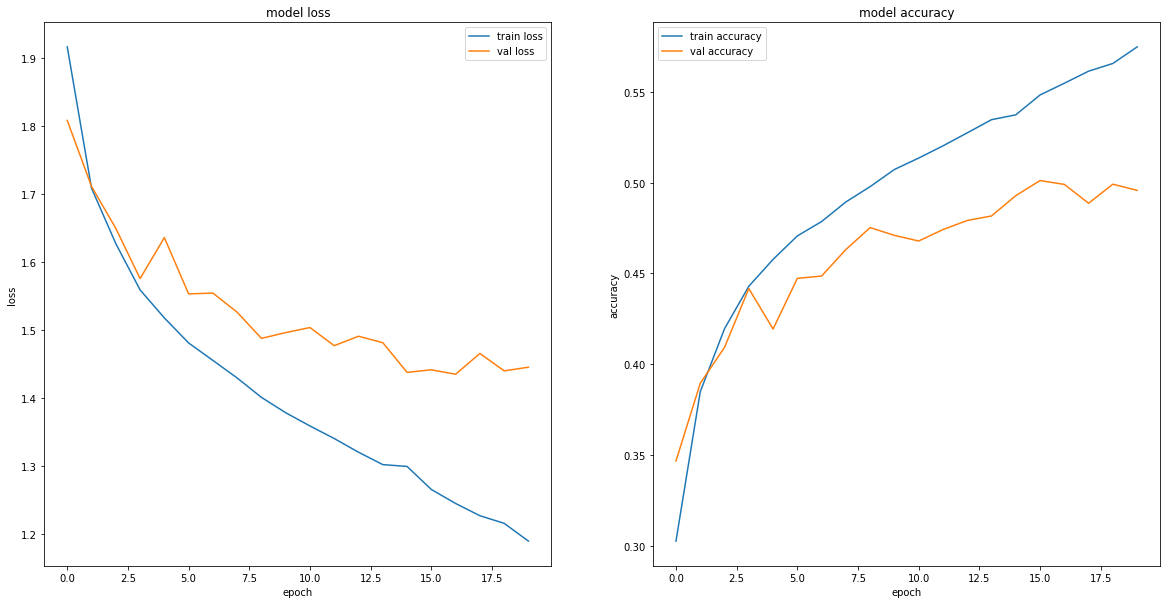

In [128]:
plot_losses(history)

In [91]:
m2 = network_2(x_train_nn.shape[1:])

In [108]:
history = m2.fit(x_train_nn, y_train_nn, 
       batch_size=BATCH_SIZE, 
       epochs = 40, 
       validation_split=0.2, 
       use_multiprocessing=True, verbose = 1)

Epoch 1/40
157/157 [==============================] - 2s 10ms/step - loss: 1.5379 - accuracy: 0.4439 - val_loss: 1.5455 - val_accuracy: 0.4443
Epoch 2/40
157/157 [==============================] - 2s 10ms/step - loss: 1.5330 - accuracy: 0.4455 - val_loss: 1.5165 - val_accuracy: 0.4613
Epoch 3/40
157/157 [==============================] - 2s 10ms/step - loss: 1.5175 - accuracy: 0.4497 - val_loss: 1.5127 - val_accuracy: 0.4568
Epoch 4/40
157/157 [==============================] - 2s 10ms/step - loss: 1.5097 - accuracy: 0.4534 - val_loss: 1.5368 - val_accuracy: 0.4521
Epoch 5/40
157/157 [==============================] - 2s 10ms/step - loss: 1.5123 - accuracy: 0.4544 - val_loss: 1.5265 - val_accuracy: 0.4602
Epoch 6/40
157/157 [==============================] - 2s 10ms/step - loss: 1.5041 - accuracy: 0.4557 - val_loss: 1.5109 - val_accuracy: 0.4592
Epoch 7/40
157/157 [==============================] - 2s 10ms/step - loss: 1.5052 - accuracy: 0.4529 - val_loss: 1.5003 - val_accuracy: 0.4618

In [109]:
y_pred = m2.predict(x_test_nn)

In [110]:
y_pred = y_pred.argmax(axis = 1)

In [111]:
print(classification_report(y_pred, y_test.reshape(-1), target_names=labels))

              precision    recall  f1-score   support

    airplane       0.42      0.64      0.51       653
  automobile       0.44      0.64      0.52       679
        bird       0.34      0.34      0.34      1005
         cat       0.28      0.31      0.29       887
        deer       0.52      0.35      0.41      1497
         dog       0.25      0.47      0.32       525
        frog       0.56      0.46      0.51      1201
       horse       0.56      0.47      0.51      1191
        ship       0.57      0.63      0.60       904
       truck       0.67      0.46      0.54      1458

    accuracy                           0.46     10000
   macro avg       0.46      0.48      0.46     10000
weighted avg       0.49      0.46      0.46     10000



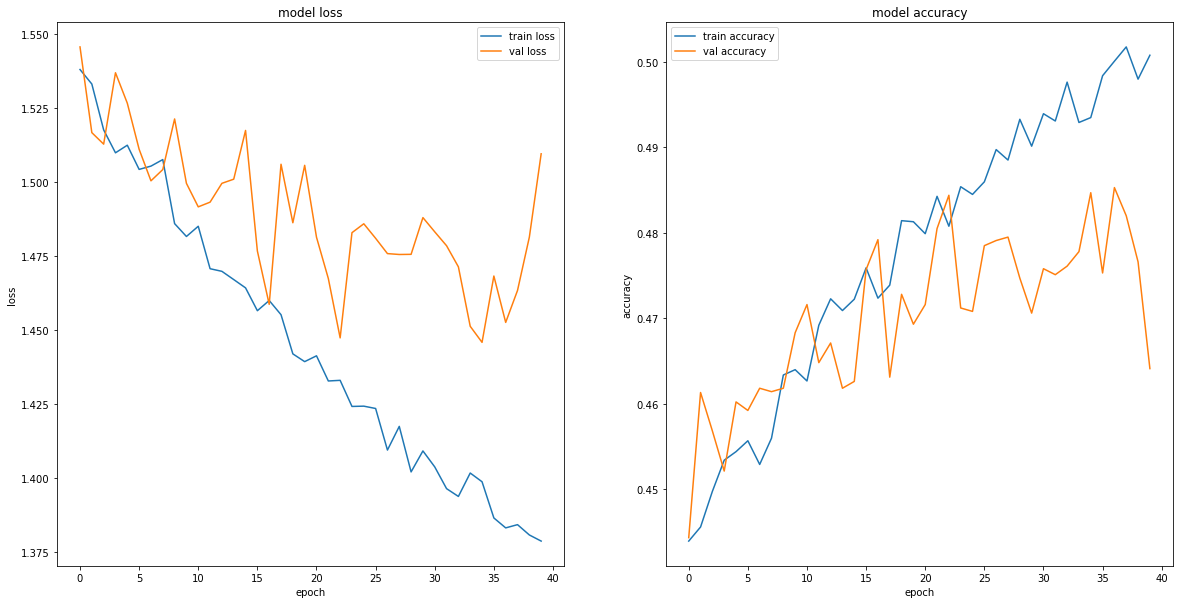

In [119]:
plot_losses(history)

## Method 4 - Deep Neural Network with Convolution¶

In [ ]:
def load_dataset_cnn():
    #Download and prepare the CIFAR 10 Dataset
    (train_images, train_labels),(test_images,test_labels) = datasets.cifar10.load_data()

    #Normalilse pixel values between 0 and 1
    train_images, test_images = train_images/255.0, test_images/255.0
    return train_images, train_labels,test_images,test_labels

In [ ]:
def verify_dataset_cnn(train_images,train_labels):
    #Verfiy the dataset
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

    plt.figure(figsize=(10,10))

    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[i])
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        plt.xlabel(class_names[train_labels[i][0]])
    plt.show()


Dataset looks good. 

Moving on, lets create the Convolutional Neural Network.




In [ ]:
#Define Model Creating Function
def define_model_cnn1():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer = 'he_uniform',padding = 'same',input_shape=(32, 32, 3)))
    model.add(layers.Conv2D(32, (3,3), activation='relu',kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu',kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu',kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = 'relu',kernel_initializer = 'he_uniform'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10, activation = 'softmax'))
    model.summary()

    return model


In [ ]:
def get_data():
    #loading the dataset
    train_images, train_labels, test_images, test_labels = load_dataset_cnn()

    #verifying the data
    verify_dataset_cnn(train_images,train_labels)
    return train_images, train_labels, test_images, test_labels

In [ ]:
def run_model(cnn, train_images, train_labels, test_images, test_labels):


    cnn.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    #Run model
    history = cnn.fit(train_images, train_labels, epochs=50, 
                    validation_data=(test_images, test_labels))

    test_loss, test_acc  = cnn.evaluate(test_images, test_labels, verbose=2)

    print(test_acc)

    #Plot the Accuracy
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    y_preds = cnn.predict(test_images)
    y_preds = y_preds.argmax(axis = 1).astype(np.uint8)
    test_loss, test_acc = cnn.evaluate(test_images,  test_labels, verbose=2)

    return y_preds,test_loss, test_acc, history



Load Data



170508288/170498071 [==============================] - 11s 0us/step


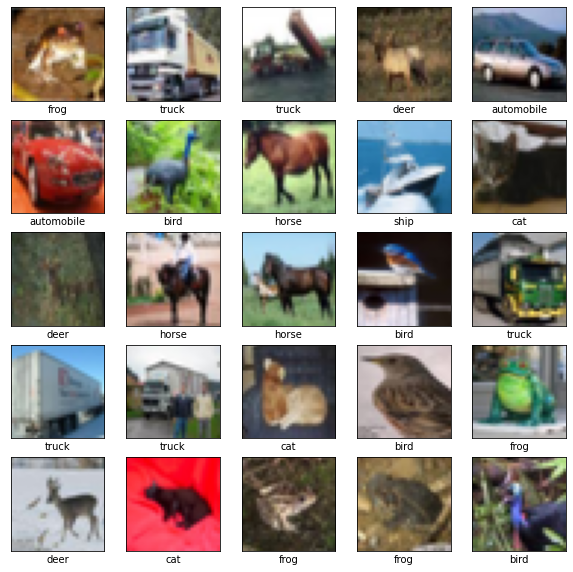

In [ ]:
train_images, train_labels, test_images, test_labels = get_data()

CNN #1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 38s 17ms/step - loss: 1.6244 - accuracy: 0.4035 - val_loss: 1.2216 - val_accuracy: 0.5621
Epoch 2/50
1563/1563 [==============================] - 27s 17ms/step - loss: 1.1520 - accuracy: 0.5874 - val_loss: 0.9786 - val_accuracy: 0.6551
Epoch 3/50
1563/1563 [==============================] - 25s 16ms/step - loss: 0.9547 - accuracy: 0.6639 - val_loss: 0.7984 - val_accuracy: 0.7199
Epoch 4/50
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8408 - accuracy: 0.7072 - val_loss: 0.7780 - val_accuracy: 0.7300
Epoch 5/50
1563/1563 [==============================] - 26s 17ms/step - loss: 0.7697 - accuracy: 0.7320 - val_loss: 0.7189 - val_accuracy: 0.7559
Epoch 6/50
1563/1563 [==============================] - 26s 17ms/step - loss: 0.7136 - accuracy: 0.7516 - val_loss: 0.6803 - val_accuracy: 0.7649
Epoch 7/50
1563/1563 [==============================] - 26s 17ms/step - loss: 0.6691 - accuracy: 0.7678 - val_loss: 0.6894 - val_accura

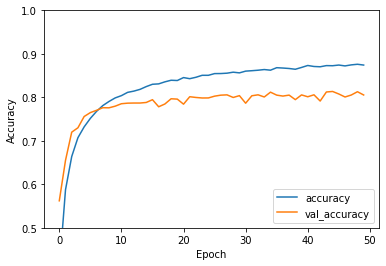

In [ ]:
cnn1 = define_model_cnn1()
y_preds,loss_1, acc_1, history = run_model(cnn1,train_images, train_labels, test_images, test_labels)

In [ ]:
print("Classification Report: CNN \n")
print(metrics.classification_report(list(y_preds), list(test_labels.reshape(-1)), 
                              target_names = labels))

Classification Report: CNN 

              precision    recall  f1-score   support

    airplane       0.82      0.86      0.84       954
  automobile       0.91      0.90      0.91      1012
        bird       0.69      0.80      0.74       856
         cat       0.58      0.68      0.63       843
        deer       0.81      0.74      0.77      1103
         dog       0.77      0.70      0.73      1097
        frog       0.89      0.78      0.83      1149
       horse       0.85      0.82      0.84      1044
        ship       0.88      0.90      0.89       979
       truck       0.86      0.89      0.88       963

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.80     10000
weighted avg       0.81      0.81      0.81     10000



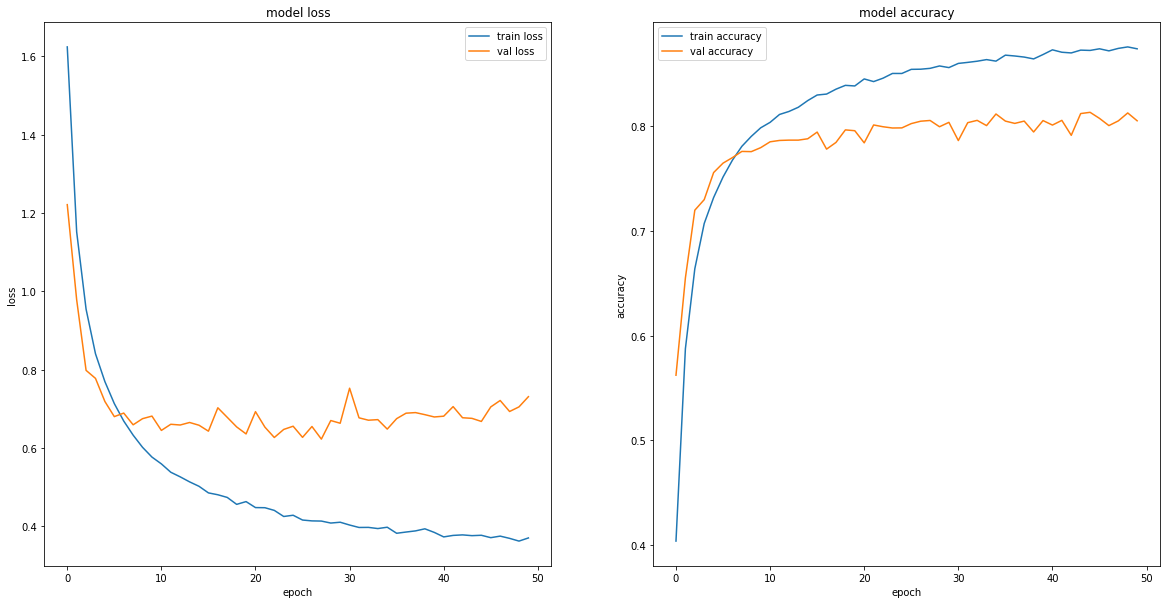

In [ ]:
plot_losses(history)